In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import sys
print(sys.version)

['sample_submission.csv', 'plates.zip']
3.6.6 |Anaconda, Inc.| (default, Oct  9 2018, 12:34:16) 
[GCC 7.3.0]


In [2]:
import zipfile

# let's look at the contents of the archive
data = zipfile.ZipFile('../input/plates.zip', 'r')
# data_r.printdir()

# extract the contents
data.extractall()

# let's look at the working directory
os.getcwd()

# contents of the working directory
print(os.listdir('../working'))

# contents of our directory
data_root = '../working/plates'
print(os.listdir(data_root))

['.ipynb_checkpoints', '__notebook_source__.ipynb', '__MACOSX', 'plates']
['.DS_Store', 'train', 'test']


In [3]:
!ls ../working/plates

test  train


In [4]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 3574.98it/s]


In [5]:
!ls plates

test  train


In [6]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import models
from torchvision import transforms


train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# train_transforms_2 = transforms.Compose([
#     transforms.RandomResizedCrop(224),
#     transforms.RandomRotation(degrees=15),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# train_transforms_3 = transforms.Compose([
#     transforms.RandomResizedCrop(224),
#     transforms.RandomVerticalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# train_transforms_4 = transforms.Compose([
#     transforms.RandomResizedCrop(224),
#     transforms.ColorJitter(),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# train_dataset_1 = torchvision.datasets.ImageFolder(train_dir, train_transforms_1)
# train_dataset_2 = torchvision.datasets.ImageFolder(train_dir, train_transforms_2)
# train_dataset_3 = torchvision.datasets.ImageFolder(train_dir, train_transforms_3)

# train_dataset = torch.utils.data.ConcatDataset([train_dataset_1, train_dataset_2, train_dataset_3])
train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [7]:
len(train_dataloader), len(train_dataset)

(5, 34)

In [8]:
len(val_dataloader), len(val_dataset)

(1, 6)

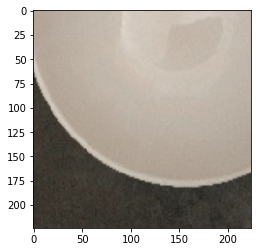

In [9]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

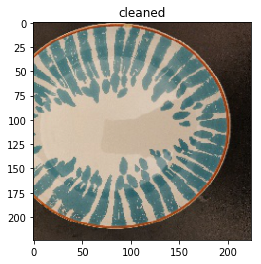

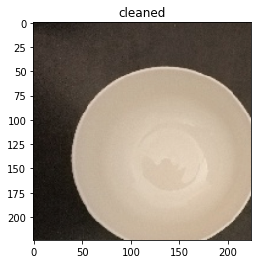

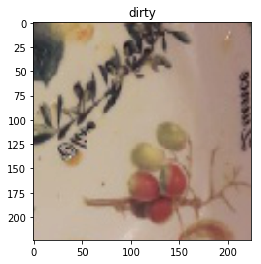

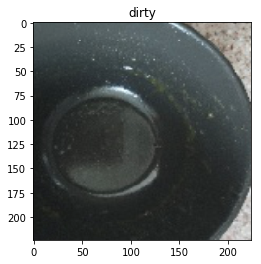

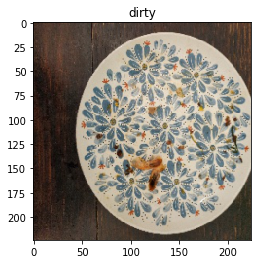

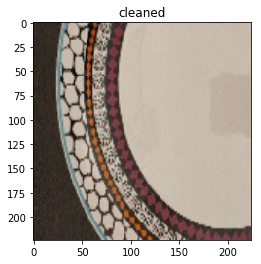

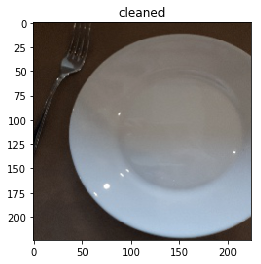

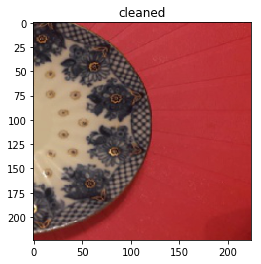

In [10]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [11]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase=='train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [12]:
model = models.resnet34(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 110706576.23it/s]


In [13]:
train_model(model, loss, optimizer, scheduler, num_epochs=100);

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 9.4423 Acc: 0.4250


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 11.9103 Acc: 0.5000
Epoch 1/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 8.6343 Acc: 0.4500


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 15.0833 Acc: 0.5000
Epoch 2/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 7.9292 Acc: 0.7500


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 22.0668 Acc: 0.5000
Epoch 3/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 26.5836 Acc: 0.5750


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 35.1158 Acc: 0.5000
Epoch 4/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 20.6395 Acc: 0.7000


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 19.5832 Acc: 0.6667
Epoch 5/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 11.5739 Acc: 0.6500


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 11.8706 Acc: 0.5000
Epoch 6/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 22.9327 Acc: 0.6500


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 4.8733 Acc: 0.8333
Epoch 7/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 5.5120 Acc: 0.8500


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 8.7016 Acc: 0.6667
Epoch 8/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 13.4590 Acc: 0.8000


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 20.5666 Acc: 0.6667
Epoch 9/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 2.3510 Acc: 0.9250


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 12.9944 Acc: 0.6667
Epoch 10/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 2.8825 Acc: 0.9250


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 5.6007 Acc: 0.8333
Epoch 11/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 6.1299 Acc: 0.8000


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.6289 Acc: 0.8333
Epoch 12/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 5.4156 Acc: 0.8000


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.4833 Acc: 0.8333
Epoch 13/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 15.6133 Acc: 0.8250


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 3.3469 Acc: 0.6667
Epoch 14/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 7.7927 Acc: 0.7250


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.4688 Acc: 0.8333
Epoch 15/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 14.1946 Acc: 0.8250


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.1246 Acc: 0.8333
Epoch 16/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 9.5829 Acc: 0.8000


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.2430 Acc: 0.8333
Epoch 17/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 3.3984 Acc: 0.7750


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.3820 Acc: 0.8333
Epoch 18/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 2.8095 Acc: 0.9250


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.8628 Acc: 0.8333
Epoch 19/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 3.3952 Acc: 0.8750


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.7984 Acc: 0.8333
Epoch 20/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 6.4234 Acc: 0.8000


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0000 Acc: 1.0000
Epoch 21/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 8.5602 Acc: 0.7750


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0000 Acc: 1.0000
Epoch 22/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 3.0986 Acc: 0.9000


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0591 Acc: 1.0000
Epoch 23/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 1.6841 Acc: 0.9250


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0273 Acc: 1.0000
Epoch 24/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 5.1947 Acc: 0.8000


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0928 Acc: 1.0000
Epoch 25/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 7.4848 Acc: 0.8000


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.2191 Acc: 0.8333
Epoch 26/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 3.2577 Acc: 0.9000


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.1691 Acc: 0.8333
Epoch 27/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 12.0293 Acc: 0.7500


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6812 Acc: 0.8333
Epoch 28/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 3.9882 Acc: 0.9250


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0357 Acc: 1.0000
Epoch 29/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 5.1904 Acc: 0.8500


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0001 Acc: 1.0000
Epoch 30/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 3.2182 Acc: 0.8500


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0002 Acc: 1.0000
Epoch 31/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 2.3648 Acc: 0.8000


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.4968 Acc: 0.8333
Epoch 32/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 2.6759 Acc: 0.9000


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0032 Acc: 1.0000
Epoch 33/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 3.4950 Acc: 0.9250


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.5726 Acc: 0.8333
Epoch 34/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 5.3425 Acc: 0.6750


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0003 Acc: 1.0000
Epoch 35/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 5.5016 Acc: 0.8500


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0094 Acc: 1.0000
Epoch 36/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 4.1030 Acc: 0.8250


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.9137 Acc: 0.6667
Epoch 37/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 3.0837 Acc: 0.8750


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.8149 Acc: 0.8333
Epoch 38/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 5.6910 Acc: 0.9250


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.8154 Acc: 0.8333
Epoch 39/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.2869 Acc: 0.9500


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0404 Acc: 1.0000
Epoch 40/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 2.4775 Acc: 0.9250


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0001 Acc: 1.0000
Epoch 41/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 2.0485 Acc: 0.9500


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0006 Acc: 1.0000
Epoch 42/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 2.7126 Acc: 0.8750


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.3558 Acc: 0.8333
Epoch 43/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 4.8388 Acc: 0.8500


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.4391 Acc: 0.8333
Epoch 44/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 3.1439 Acc: 0.9250


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 3.2150 Acc: 0.8333
Epoch 45/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 7.7281 Acc: 0.8500


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 3.8954 Acc: 0.8333
Epoch 46/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.7249 Acc: 0.9250


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.9889 Acc: 0.8333
Epoch 47/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 4.8520 Acc: 0.7500


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.1393 Acc: 0.8333
Epoch 48/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 2.4387 Acc: 0.8250


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.3701 Acc: 0.8333
Epoch 49/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.5202 Acc: 0.9750


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.1011 Acc: 0.8333
Epoch 50/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 4.6129 Acc: 0.8000


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.4114 Acc: 0.8333
Epoch 51/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 2.1933 Acc: 0.8750


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6267 Acc: 0.8333
Epoch 52/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 1.8462 Acc: 0.9000


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0009 Acc: 1.0000
Epoch 53/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 9.6064 Acc: 0.8000


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.1695 Acc: 0.8333
Epoch 54/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 4.2640 Acc: 0.9000


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0207 Acc: 1.0000
Epoch 55/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 4.3519 Acc: 0.8000


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0011 Acc: 1.0000
Epoch 56/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.9092 Acc: 0.9250


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.9178 Acc: 0.8333
Epoch 57/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 11.1897 Acc: 0.8750


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0001 Acc: 1.0000
Epoch 58/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 4.2706 Acc: 0.9000


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0024 Acc: 1.0000
Epoch 59/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 5.8265 Acc: 0.8500


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0083 Acc: 1.0000
Epoch 60/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 6.8165 Acc: 0.8750


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.7061 Acc: 0.8333
Epoch 61/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 1.1081 Acc: 0.9250


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0014 Acc: 1.0000
Epoch 62/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 5.5121 Acc: 0.8750


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0851 Acc: 1.0000
Epoch 63/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 4.8755 Acc: 0.8250


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0007 Acc: 1.0000
Epoch 64/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 2.3710 Acc: 0.9000


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0303 Acc: 1.0000
Epoch 65/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 9.1284 Acc: 0.8000


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.1984 Acc: 0.8333
Epoch 66/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 4.5310 Acc: 0.8750


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.8446 Acc: 0.8333
Epoch 67/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 3.9941 Acc: 0.9000


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0506 Acc: 1.0000
Epoch 68/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 8.0155 Acc: 0.7750


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.5911 Acc: 0.8333
Epoch 69/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 1.2908 Acc: 0.9250


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.1252 Acc: 0.8333
Epoch 70/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 5.0834 Acc: 0.6750


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0036 Acc: 1.0000
Epoch 71/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 3.7831 Acc: 0.7250


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.1343 Acc: 0.8333
Epoch 72/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 7.7250 Acc: 0.8000


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.1553 Acc: 0.8333
Epoch 73/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 6.2472 Acc: 0.6750


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.4506 Acc: 0.8333
Epoch 74/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 5.9846 Acc: 0.8000


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0226 Acc: 1.0000
Epoch 75/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 4.3456 Acc: 0.8250


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0000 Acc: 1.0000
Epoch 76/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 6.4070 Acc: 0.8000


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0000 Acc: 1.0000
Epoch 77/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 11.8518 Acc: 0.6750


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0000 Acc: 1.0000
Epoch 78/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 6.6939 Acc: 0.8750


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0001 Acc: 1.0000
Epoch 79/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 3.6828 Acc: 0.8500


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0023 Acc: 1.0000
Epoch 80/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 2.9970 Acc: 0.8750


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0020 Acc: 1.0000
Epoch 81/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 7.7303 Acc: 0.8000


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.9501 Acc: 0.8333
Epoch 82/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 9.1680 Acc: 0.6750


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0039 Acc: 1.0000
Epoch 83/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.8634 Acc: 0.9000


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0062 Acc: 1.0000
Epoch 84/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 3.5627 Acc: 0.8750


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0001 Acc: 1.0000
Epoch 85/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 7.1487 Acc: 0.8000


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.7798 Acc: 0.8333
Epoch 86/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 5.4080 Acc: 0.8500


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0704 Acc: 1.0000
Epoch 87/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 4.7619 Acc: 0.8000


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.2266 Acc: 0.8333
Epoch 88/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 1.7956 Acc: 0.9250


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.3671 Acc: 0.8333
Epoch 89/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.2139 Acc: 0.9500


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.6311 Acc: 0.8333
Epoch 90/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 8.0377 Acc: 0.8250


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.3229 Acc: 0.8333
Epoch 91/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 5.0799 Acc: 0.8750


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.9589 Acc: 0.8333
Epoch 92/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 6.3903 Acc: 0.8000


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.4323 Acc: 0.8333
Epoch 93/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 6.7177 Acc: 0.6750


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.3345 Acc: 0.8333
Epoch 94/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 6.8589 Acc: 0.8500


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.4123 Acc: 0.8333
Epoch 95/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 4.8835 Acc: 0.8750


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.9648 Acc: 0.8333
Epoch 96/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 1.9871 Acc: 0.8250


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.3879 Acc: 0.8333
Epoch 97/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 4.2780 Acc: 0.8000


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.8000 Acc: 0.8333
Epoch 98/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 8.6533 Acc: 0.7750


  0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0067 Acc: 1.0000
Epoch 99/99:


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 1.5906 Acc: 0.8500


100%|██████████| 1/1 [00:00<00:00,  7.73it/s]

val Loss: 0.0018 Acc: 1.0000


In [14]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [15]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths(test_dir, val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [16]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:03<00:00, 26.59it/s]


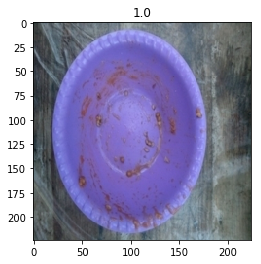

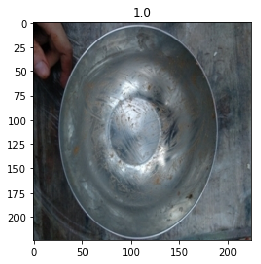

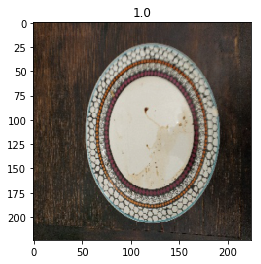

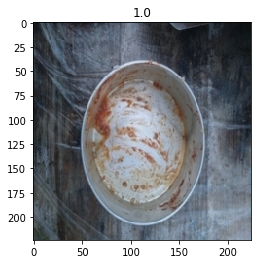

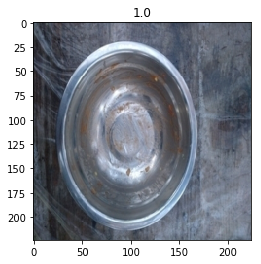

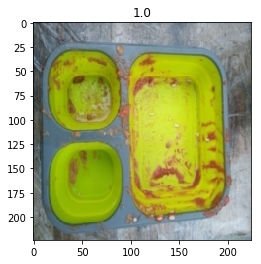

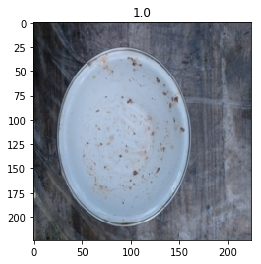

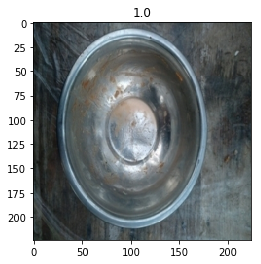

In [17]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [18]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [19]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty
0005,dirty


In [20]:
submission_df.to_csv('submission.csv')

In [21]:
!rm -rf train val test